<a href="https://colab.research.google.com/github/katemartian/LHoutputsManuscript/blob/master/LHoutputs_avoidanceTask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> LHA All tests



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/!lab/Manuscripts/LHoutputs/rawdata/

/content/drive/MyDrive/!lab/Manuscripts/LHoutputs/rawdata


In [ ]:
%run FiberPhotometryDataAnalysis_elife.ipynb

All Fiber Photometry functions are ready to use


In [ ]:
mice = ['LHA73','LHA74','LHA75','LHA76','LHA77','LHA78','LHA79','LHA80','LHA81','LHA82',
        'LHA83','LHA84','LHA86']
outputs = ['LHA-LHb', 'LHA-VTA','LHA-DRN']        
tests = ['Avoidance-Training','Avoidance-Test']

In [ ]:
filename = 'LH_avoidanceTask.h5'

# Save recordings to HDF file

In [ ]:
folders = {'AvoidanceTraining': ['/content/drive/MyDrive/!lab/!FP/2019-08-27 LHA Avoidance 1/raw/'],
               'AvoidanceTest': ['/content/drive/MyDrive/!lab/!FP/2019-09-04 LHA Avoidance 2/raw/']}

#### Avoidance-Training

In [ ]:
test = 'AvoidanceTraining'
atrain_full_file_names = []
for folder in folders[test]:
  files = find_files(folder,['green','.csv'])
  for f in files:
    mouse = f.split('_')[0]
    if mouse in mice:
      atrain_full_file_names.append(folder+f)
#atrain_full_file_names

In [ ]:
mice = []
ns = []
latencies = []

for file_ in atrain_full_file_names:

  file_split = file_.split('/') 
  name = file_split[-1]
  folder = '/'.join(file_split[:-1])

  # Experiment info ------------------------------------------------------------
  sepname = name.split('_')      
  mouse = sepname[0]
  outputs = ['LHA-'+sepname[1],'LHA-'+sepname[2],'LHA-'+sepname[3]]
  experiment = sepname[4]

 
 # Other file names -------------------------------------------------------------
  med_name = find_files(folder,[mouse,'med'])[0]
  anymaze_name = mouse+'_'+experiment+'_anymaze.csv'
 

 # Read data frames ---------------------------------------------------------
  df = pd.read_csv(folder+'/'+name,sep=' ',index_col=False)
  df_anymaze = pd.read_csv(folder+'/'+anymaze_name)


 # Twicks with time ------------------------------------------------------------
 # Test duration based on med associates experiment
  test_dur = int(round(values_from_medfile(folder+'/'+med_name,'T')[0]))
  med_cs = values_from_medfile(folder+'/'+med_name,'C')


 # Anymaze and Med time
  realtime_am = df_anymaze['Time']
  time_am = time_to_seconds(realtime_am, realtime_am[0])

 # FP time
  hour = int(realtime_am[0].split(':')[0])
  realtime_fp = create_realtime(hour,mm=list(df['Item4']),ss=list(df['Item5']),ms=list(df['Item6']))
  time_fp = time_to_seconds(realtime_fp, realtime_fp[0])

 # Find time difference between FP recordings and Med 
  dt = (pd.Timedelta(realtime_fp[0])-pd.Timedelta(realtime_am[0])).total_seconds()

 # Find stop time and adjust length of FP data frames
  stop_time = test_dur - dt
  idx_stop = find_idx(stop_time, time_fp, time_format='total seconds')
  if idx_stop % 2 == 1:
    idx_stop += 1
  df = df.iloc[:idx_stop,:]
  time_ = time_fp[:idx_stop]
  time_ = time_[::2]


 # Signal ----------------------------------------------------------------------
  references = {}
  signals = {}
  for fiber,output in enumerate(outputs):
    if output in ['LHA-1','LHA-2','LHA-3']:
      pass
    else:
      references[output] = np.array(df.iloc[1::2,fiber])
      signals[output] = np.array(df.iloc[ ::2,fiber])

  for fiber,output in enumerate(outputs):
    if output in ['LHA-1','LHA-2','LHA-3']:
      outputs.pop(fiber),


  # Behavioral events ------------------------------------------------------------
  
   # Video frame rate
  import imageio
  video_folder = '/content/drive/My Drive/!lab/DeepLabCut/LHA_Avoidance-Kate-2019-12-17/videos/'
  reader = imageio.get_reader(video_folder+mouse+'_'+experiment+'.mp4')
  fps = reader.get_meta_data()['fps']

  # DeepLabCut results
  deeplabcut_name = find_files(folder, [mouse,experiment,'DLC'])[0]
  try:
    df_deeplabcut = pd.read_csv(folder+'/'+deeplabcut_name)
  except:
    df_deeplabcut = pd.read_hdf(folder+'/'+deeplabcut_name, 'df_with_missing')

  # Left light on off
  LeftLight = np.array(df_deeplabcut[('DLC_resnet50_LHA_AvoidanceDec17shuffle1_30000', 'LeftLight', 'likelihood')])
  cs_left = event_onoffset(np.round(LeftLight))
 # Right light on off
  RightLight = np.array(df_deeplabcut[('DLC_resnet50_LHA_AvoidanceDec17shuffle1_30000', 'RightLight', 'likelihood')])
  cs_right = event_onoffset(np.round(RightLight))
 # Concat both lights to cs arrays
  cs = np.concatenate([cs_left,cs_right],axis=0)
  cs.sort(axis=0)
 # Change cs to seconds
  cs = [[e0/fps-dt,e1/fps-dt] for e0,e1 in cs]
  cs = np.array(cs).reshape(len(cs),2)
 # Remove short intervals and durations
  cs = adjust_intervals_durations(cs, 1, 1)
  

 # Remove not CS
  keep = []
  j=0
  for i in range(len(med_cs)):
    j = i
    while j < len(cs):
      if np.abs(med_cs[i]-cs[j,0]-dt<1.5):
        keep.append(j)
        break
      j+=1
  cs = cs[keep,:]
  

 # Split cs into avoidance and escape
  cs_fail = np.array([[e0,e1] for e0,e1 in cs if e1-e0 >= 8])
  cs_success = np.array([[e0,e1] for e0,e1 in cs if e1-e0 < 8])

  if len(cs_success)!=0:
    n_avoid = len(cs_success)
    latency_avoid = np.mean(cs_success[:,1]-cs_success[:,0])
  else:
    n_avoid = 0
    latency_avoid = np.nan
  n_escape = len(cs_fail)
  latency_escape = np.mean(cs_fail[:,1]-cs_fail[:,0])
  
  n = n_avoid+n_escape
  mice.append(mouse)
  ns.append(n_avoid/n)
  latencies.append(np.mean(cs[:,1]-cs[:,0]))

  cs_escape = cs_fail[:,0].reshape(len(cs_fail),1)
  cs_avoidance = [] if len(cs_success)==0 else cs_success[:,0].reshape(len(cs_success),1)
  escape =  cs_fail[:,1].reshape(len(cs_fail),1)
  avoidance = [] if len(cs_success)==0 else cs_success[:,1].reshape(len(cs_success),1)
  

 # Speed
  x = np.array(df_deeplabcut[('DLC_resnet50_LHA_AvoidanceDec17shuffle1_30000', 'Body', 'x')])
  y = np.array(df_deeplabcut[('DLC_resnet50_LHA_AvoidanceDec17shuffle1_30000', 'Body', 'y')])
  speed_time = np.arange(0,len(x)/fps,1/fps)-dt
  speed = get_speed(x,y,speed_time)

  movement = np.interp(speed, (np.nanmin(speed),np.nanmax(speed)), (0,1))

 # Adjust the begining of escape and avoidance
  for e in range(len(escape)):
    i_off = find_idx(escape[e],speed_time)
    if cs_escape[e]+10 > escape[e]:
      i_on = find_idx(cs_escape[e]+7.5,speed_time)
    else:
      i_on = find_idx(escape[e]-2,speed_time)
    i_min = i_off - np.argmin(movement[i_off:i_on:-1])
    escape[e] = speed_time[i_min]


  for a in range(len(avoidance)):
    i_off = find_idx(avoidance[a],speed_time)
    if cs_avoidance[a]+2 > avoidance[a]:
      i_on = find_idx(cs_avoidance[a],speed_time)
    else:
      i_on = find_idx(avoidance[a]-2,speed_time)
    i_min = i_off - np.argmin(movement[i_off:i_on:-1])
    avoidance[a] = speed_time[i_min]
  

 # Events
  events = {'CS-escape': cs_fail,
         'CS-avoidance': cs_success,
             'escapeCS': cs_escape,
          'avoidanceCS': cs_avoidance,
               'escape': escape,
            'avoidance': avoidance}


 # Measurements
  measurements = {'movement': {'values': movement,
                                 'time': speed_time}}
  
  raw = FiberPhotometryRecording(signals,references,time_,events,measurements,mouse,'Avoidance-Training',trial='1')
  raw.saveRecording(filename)
  print(raw.mouse,raw.test,raw.trial,raw.outputs)

df_atrain = pd.DataFrame({'mice': mice,
                          'training': ['Early']*len(mice),
                          'number': ns,
                          'latency': latencies})


LHA73 Avoidance-Training 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']
LHA74 Avoidance-Training 1 ['LHA-LHb', 'LHA-VTA']
LHA75 Avoidance-Training 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']
LHA77 Avoidance-Training 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']
LHA78 Avoidance-Training 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']
LHA79 Avoidance-Training 1 ['LHA-DRN']
LHA84 Avoidance-Training 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']
LHA86 Avoidance-Training 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']


#### Avoidance-Test

In [ ]:
test = 'AvoidanceTest'
atest_full_file_names = []
for folder in folders[test]:
  files = find_files(folder,['green','.csv'])
  for f in files:
    mouse = f.split('_')[0]
    if mouse in mice:
      atest_full_file_names.append(folder+f)
#atest_full_file_names

In [ ]:
mice = []
ns = []
latencies = []

for file_ in atest_full_file_names:

  file_split = file_.split('/') 
  name = file_split[-1]
  folder = '/'.join(file_split[:-1])

  # Experiment info ------------------------------------------------------------
  sepname = name.split('_')      
  mouse = sepname[0]
  outputs = ['LHA-'+sepname[1],'LHA-'+sepname[2],'LHA-'+sepname[3]]
  experiment = sepname[4]

 
 # Other file names -------------------------------------------------------------
  med_name = find_files(folder,[mouse,'med'])[0]
  anymaze_name = mouse+'_'+experiment+'_anymaze.csv'
 

 # Read data frames ---------------------------------------------------------
  df = pd.read_csv(folder+'/'+name,sep=' ',index_col=False)
  df_anymaze = pd.read_csv(folder+'/'+anymaze_name)

 # Twicks with time ------------------------------------------------------------
 # Test duration based on med associates experiment
  test_dur = int(round(values_from_medfile(folder+'/'+med_name,'T')[0]))

 # Anymaze and Med time
  realtime_am = df_anymaze['Time']
  time_am = time_to_seconds(realtime_am, realtime_am[0])

 # FP time
  hour = int(realtime_am[0].split(':')[0])
  realtime_fp = create_realtime(hour,mm=list(df['Item4']),ss=list(df['Item5']),ms=list(df['Item6']))
  time_fp = time_to_seconds(realtime_fp, realtime_fp[0])

 # Find time difference between FP recordings and Med 
  dt = (pd.Timedelta(realtime_fp[0])-pd.Timedelta(realtime_am[0])).total_seconds()

 # Find stop time and adjust length of FP data frames
  stop_time = test_dur - dt
  idx_stop = find_idx(stop_time, time_fp, time_format='total seconds')
  if idx_stop % 2 == 1:
    idx_stop += 1
  df = df.iloc[:idx_stop,:]
  time_ = time_fp[:idx_stop]
  time_ = time_[::2]


 # Signal ----------------------------------------------------------------------
  references = {}
  signals = {}
  for fiber,output in enumerate(outputs):
    if output in ['LHA-1','LHA-2','LHA-3']:
      pass
    else:
      references[output] = np.array(df.iloc[1::2,fiber])
      signals[output] = np.array(df.iloc[ ::2,fiber])
      #print(references[output].size)

  for fiber,output in enumerate(outputs):
    if output in ['LHA-1','LHA-2','LHA-3']:
      outputs.pop(fiber),


  # Behavioral events ------------------------------------------------------------
  
   # Video frame rate
  import imageio
  video_folder = '/content/drive/My Drive/!lab/DeepLabCut/LHA_Avoidance-Kate-2019-12-17/videos/'
  reader = imageio.get_reader(video_folder+mouse+'_'+experiment+'.mp4')
  fps = reader.get_meta_data()['fps']

  # DeepLabCut results
  deeplabcut_name = find_files(folder, [mouse,experiment,'DLC'])[0]
  try:
    df_deeplabcut = pd.read_csv(folder+'/'+deeplabcut_name)
  except:
    df_deeplabcut = pd.read_hdf(folder+'/'+deeplabcut_name, 'df_with_missing')

  # Left light on off
  LeftLight = np.array(df_deeplabcut[('DLC_resnet50_LHA_AvoidanceDec17shuffle1_30000', 'LeftLight', 'likelihood')])
  cs_left = event_onoffset(np.round(LeftLight))
 # Right light on off
  RightLight = np.array(df_deeplabcut[('DLC_resnet50_LHA_AvoidanceDec17shuffle1_30000', 'RightLight', 'likelihood')])
  cs_right = event_onoffset(np.round(RightLight))
 # Concat both lights to cs arrays
  cs = np.concatenate([cs_left,cs_right],axis=0)
  cs.sort(axis=0)
 # Change cs to seconds
  cs = [[e0/fps-dt,e1/fps-dt] for e0,e1 in cs]
  cs = np.array(cs).reshape(len(cs),2)
 # Remove short intervals and durations
  cs = adjust_intervals_durations(cs, 1, 1)
 # Split cs into avoidance and escape
  cs_fail = np.array([[e0,e1] for e0,e1 in cs if e1-e0 >= 8])
  cs_success = np.array([[e0,e1] for e0,e1 in cs if e1-e0 < 8])

  if len(cs_success)!=0:
    n_avoid = len(cs_success)
    latency_avoid = np.mean(cs_success[:,1]-cs_success[:,0])
  n_escape = len(cs_fail)
  latency_escape = np.mean(cs_fail[:,1]-cs_fail[:,0])

  n = n_avoid+n_escape
  mice.append(mouse)
  ns.append(n_avoid/n)
  latencies.append(np.mean(cs[:,1]-cs[:,0]))


  cs_escape = cs_fail[:,0].reshape(len(cs_fail),1)
  cs_avoidance = [] if len(cs_success)==0 else cs_success[:,0].reshape(len(cs_success),1)
  escape =  cs_fail[:,1].reshape(len(cs_fail),1)
  avoidance = [] if len(cs_success)==0 else cs_success[:,1].reshape(len(cs_success),1)
  #print(avoidance)


 # Speed
  x = np.array(df_deeplabcut[('DLC_resnet50_LHA_AvoidanceDec17shuffle1_30000', 'Body', 'x')])
  y = np.array(df_deeplabcut[('DLC_resnet50_LHA_AvoidanceDec17shuffle1_30000', 'Body', 'y')])
  speed_time = np.arange(0,len(x)/fps,1/fps)-dt
  speed = get_speed(x,y,speed_time)

  movement = np.interp(speed, (np.nanmin(speed),np.nanmax(speed)), (0,1))

 # Adjust the begining of escape and avoidance
  for e in range(len(escape)):
    i_off = find_idx(escape[e],speed_time)
    if cs_escape[e]+10 > escape[e]:
      i_on = find_idx(cs_escape[e]+7.5,speed_time)
    else:
      i_on = find_idx(escape[e]-2,speed_time)
    if i_on == i_off:
      i_min = i_on
    else:
      i_min = i_off - np.argmin(movement[i_off:i_on:-1])
    escape[e] = speed_time[i_min]


  for a in range(len(avoidance)):
    i_off = find_idx(avoidance[a],speed_time)
    if cs_avoidance[a]+2 > avoidance[a]:
      i_on = find_idx(cs_avoidance[a],speed_time)
    else:
      i_on = find_idx(avoidance[a]-2,speed_time)
    i_min = i_off - np.argmin(movement[i_off:i_on:-1])
    avoidance[a] = speed_time[i_min]
  

 # Events
  events = {'CS-escape': cs_fail,
         'CS-avoidance': cs_success,
             'escapeCS': cs_escape,
          'avoidanceCS': cs_avoidance,
               'escape': escape,
            'avoidance': avoidance}

 # Measurements
  measurements = {'movement': {'values': movement,
                                 'time': speed_time}}


  
  raw = FiberPhotometryRecording(signals,references,time_,events,measurements,mouse,'Avoidance-Test',trial='1')
  raw.saveRecording(filename)
  print(raw.mouse,raw.test,raw.trial,raw.outputs)

df_atest = pd.DataFrame({'mice': mice,
                          'training': ['Late']*len(mice),
                          'number': ns,
                          'latency': latencies})

LHA74 Avoidance-Test 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']
LHA78 Avoidance-Test 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']
LHA79 Avoidance-Test 1 ['LHA-DRN']
LHA75 Avoidance-Test 1 ['LHA-VTA', 'LHA-LHb']
LHA86 Avoidance-Test 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']
LHA84 Avoidance-Test 1 ['LHA-LHb', 'LHA-VTA', 'LHA-DRN']


#### Learning to avoid

In [ ]:
df_learn = pd.concat([df_atrain,df_atest])

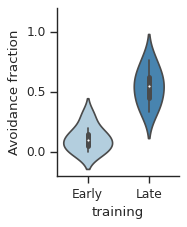

In [ ]:
sns.set(style="ticks")
fig = plt.figure(figsize=(2.5,3))
ax = fig.add_subplot()
sns.violinplot(x='training',y='number',data=df_learn, palette='Blues')

ax.set_ylabel('Avoidance fraction')
ax.set_yticks([0,0.5,1])

sns.despine()
plt.tight_layout()
plt.show()

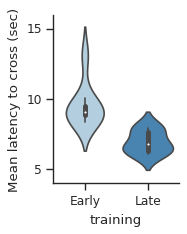

In [ ]:
sns.set(style="ticks")
fig = plt.figure(figsize=(2.5,3))
ax = fig.add_subplot()
sns.violinplot(x='training',y='latency',data=df_learn, palette='Blues')

ax.set_ylabel('Mean latency to cross (sec)')
ax.set_yticks([5,10,15])

sns.despine()
plt.tight_layout()
plt.show()

# Process data

In [ ]:
info_for_array = {'CS-escape': {'window': [-5,5],
                           'avg_frame': [-2,-1],
                             'figsize': (24,10)},          
             'CS-avoidance': {'window': [-5,5],
                           'avg_frame': [-2,-1],
                             'figsize': (24,10)},
                 'escapeCS': {'window': [-5,15],
                           'avg_frame': [-2,-1],
                             'figsize': (24,10)},
              'avoidanceCS': {'window': [-5,15],
                           'avg_frame': [-2,-1],
                             'figsize': (24,10)},
                   'escape': {'window': [-5,5],
                           'avg_frame': [-2,-1],
                             'figsize': (12,10)},
                'avoidance': {'window': [-5,5],
                           'avg_frame': [-2,-1],
                             'figsize': (12,10)}}

In [ ]:
for test in ['Avoidance-Training','Avoidance-Test']:
  for mouse in mice:

        r = FiberPhotometryRecording()
        r.loadRecording(filename,mouse,test,'1')
        if r.rawSignals != {}:
          r.getDFF(airpls_lambda=5e3,smooth_win=1.5)#,plot=True,save=True)
          if r.measurements is not None:
            r.smoothMeasurements(smooth_win=2)
            r.interpolateMeasurements()
          r.getPerievents(info_for_array)#,plot=True,save=True)
          r.saveRecording(filename)
        del r

The recording for mouse LHA74 in the experiment Avoidance-Training-1 is successfully loaded.
The recording for mouse LHA78 in the experiment Avoidance-Training-1 is successfully loaded.
The recording for mouse LHA79 in the experiment Avoidance-Training-1 is successfully loaded.
The recording for mouse LHA75 in the experiment Avoidance-Training-1 is successfully loaded.
The recording for mouse LHA86 in the experiment Avoidance-Training-1 is successfully loaded.
The recording for mouse LHA84 in the experiment Avoidance-Training-1 is successfully loaded.
The recording for mouse LHA74 in the experiment Avoidance-Test-1 is successfully loaded.
The recording for mouse LHA78 in the experiment Avoidance-Test-1 is successfully loaded.
The recording for mouse LHA79 in the experiment Avoidance-Test-1 is successfully loaded.
The recording for mouse LHA75 in the experiment Avoidance-Test-1 is successfully loaded.
The recording for mouse LHA86 in the experiment Avoidance-Test-1 is successfully loade

# Summary plots for figures

### Set attributes to the HDF file

In [ ]:
with h5py.File(filename,'a') as f:
  f.attrs['mice'] = mice
  f.attrs['outputs'] = outputs
  f.attrs['tests'] = tests

In [ ]:
with h5py.File(filename, 'a') as f:
  f.attrs['good recordings'] = [['LHA73','Avoidance-Training','1','LHA-VTA'],
                                ['LHA73','Avoidance-Training','1','LHA-DRN'],
                                ['LHA74','Avoidance-Training','1','LHA-LHb'],
                                ['LHA74','Avoidance-Training','1','LHA-VTA'],
                                ['LHA74','Avoidance-Training','1','LHA-DRN'],
                                ['LHA75','Avoidance-Training','1','LHA-VTA'],
                                ['LHA75','Avoidance-Training','1','LHA-DRN'],
                                ['LHA78','Avoidance-Training','1','LHA-LHb'],
                                ['LHA78','Avoidance-Training','1','LHA-VTA'],
                                ['LHA78','Avoidance-Training','1','LHA-DRN'],
                                ['LHA84','Avoidance-Training','1','LHA-LHb'],
                                ['LHA84','Avoidance-Training','1','LHA-VTA'],
                                ['LHA86','Avoidance-Training','1','LHA-VTA'],
                                ['LHA86','Avoidance-Training','1','LHA-DRN'],
                                ['LHA74','Avoidance-Test','1','LHA-VTA'],
                                ['LHA75','Avoidance-Test','1','LHA-LHb'],
                                ['LHA78','Avoidance-Test','1','LHA-VTA'],
                                ['LHA78','Avoidance-Test','1','LHA-DRN'],
                                ['LHA79','Avoidance-Test','1','LHA-DRN'],
                                ['LHA84','Avoidance-Test','1','LHA-LHb'],
                                ['LHA86','Avoidance-Test','1','LHA-LHb'],
                                ['LHA86','Avoidance-Test','1','LHA-VTA']]

### Avoidance-Training

In [ ]:
atrain = FiberPhotometryTest(filename,'Avoidance-Training')

Experiment information for test Avoidance-Training is successfully loaded.


In [ ]:
atrain.getMeans(auc_frames={'avoidanceCS-onset': [[-2,-1],[0,8],[8,11]],
                              'escapeCS-onset': [[-2,-1],[0,8],[8,11]],
                             'avoidance-onset': [[-2,-1],[-1,0],[0,1.5],[1.5,3]],
                                'escape-onset': [[-2,-1],[-1,0],[0,1.5],[1.5,3]]},
        perievent_windows={'avoidanceCS-onset': [-5,15],
                              'escapeCS-onset': [-5,15]})

#### CS before escape

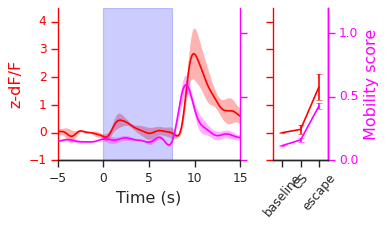

In [ ]:
atrain.plotMeans('LHA-LHb','escapeCS',color='red',
                 plot_type='mean and SEM',plot_event=[0,7.5],
                 measure='movement',periods=['baseline','CS','escape'],
                 w=[-5,15],ylim=[-1,4.5],xlim=[-5,15],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,1.5],figsize=(5,3),save=True)
plt.show()

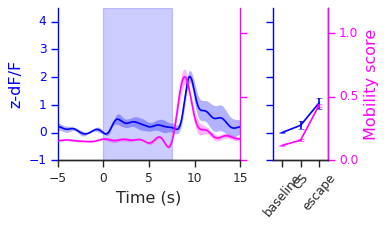

In [ ]:
atrain.plotMeans('LHA-VTA','escapeCS',color='blue',
                 plot_type='mean and SEM',plot_event=[0,7.5],
                 measure='movement',periods=['baseline','CS','escape'],
                 w=[-5,15],ylim=[-1,4.5],xlim=[-5,15],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,1.5],figsize=(5,3))
plt.show()

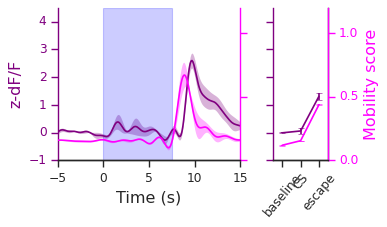

In [ ]:
atrain.plotMeans('LHA-DRN','escapeCS',color='purple',
                 plot_type='mean and SEM',plot_event=[0,7.5],
                 measure='movement',periods=['baseline','CS','escape'],
                 w=[-5,15],ylim=[-1,4.5],xlim=[-5,15],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,1.5],figsize=(5,3),save=True)
plt.show()

#### Mobility onset at escape

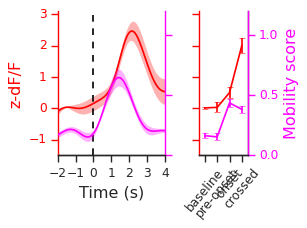

In [ ]:
atrain.plotMeans('LHA-LHb','escape',color='red',
                 plot_type='mean and SEM',
                 measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                 ylim=[-1.5,3.1],xlim=[-2,4],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,2.3],figsize=(4,3))
plt.show()

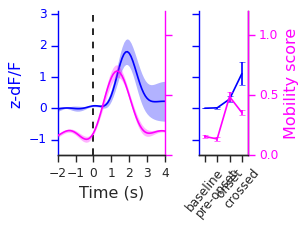

In [ ]:
atrain.plotMeans('LHA-VTA','escape',color='blue',
                 plot_type='mean and SEM',
                 measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                 ylim=[-1.5,3.1],xlim=[-2,4],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,2.3],figsize=(4,3))
plt.show()

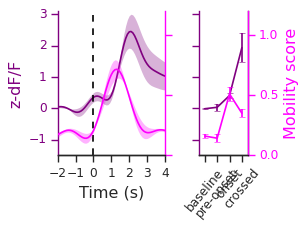

In [ ]:
atrain.plotMeans('LHA-DRN','escape',color='purple',
                 plot_type='mean and SEM',
                 measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                 ylim=[-1.5,3.1],xlim=[-2,4],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,2.3],figsize=(4,3))
plt.show()

#### CS before avoidance

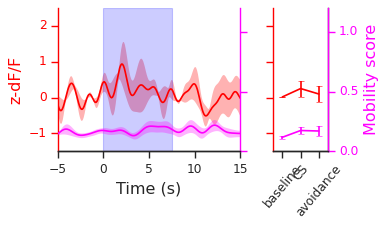

In [ ]:
atrain.plotMeans('LHA-LHb','avoidanceCS',color='red',
                 plot_type='mean and SEM',plot_event=[0,7.5],
                 measure='movement',periods=['baseline','CS','avoidance'],
                 w=[-5,15],ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-5,15],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,1.5],figsize=(5,3),save=True)
plt.show()

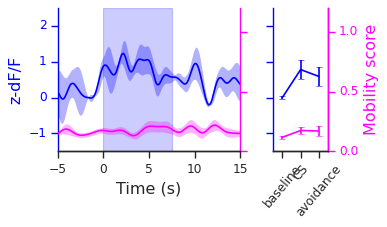

In [ ]:
atrain.plotMeans('LHA-VTA','avoidanceCS',color='blue',
                 plot_type='mean and SEM',plot_event=[0,7.5],
                 measure='movement',periods=['baseline','CS','avoidance'],
                 w=[-5,15],ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-5,15],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,1.5],figsize=(5,3))
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


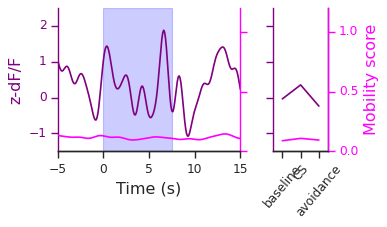

In [ ]:
atrain.plotMeans('LHA-DRN','avoidanceCS',color='purple',
                 plot_type='mean and SEM',plot_event=[0,7.5],
                 measure='movement',periods=['baseline','CS','avoidance'],
                 w=[-5,15],ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-5,15],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,1.5],figsize=(5,3),save=True)
plt.show()

#### Mobility onset at avoidance

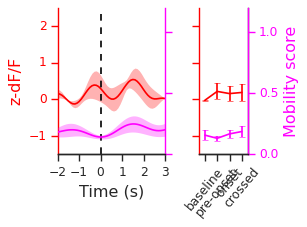

In [ ]:
atrain.plotMeans('LHA-LHb','avoidance', color='red',
                 plot_type='mean and SEM',
                 measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                 ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-2,3],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,2.3],figsize=(4,3))
plt.show()

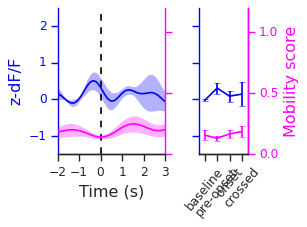

In [ ]:
atrain.plotMeans('LHA-VTA','avoidance',color='blue',
                 plot_type='mean and SEM',
                 measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                 ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-2,3],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,2.3],figsize=(4,3))
plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:224: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


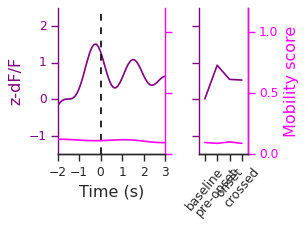

In [ ]:
atrain.plotMeans('LHA-DRN','avoidance',color='purple',
                 plot_type='mean and SEM',
                 measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                 ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-2,3],
                 ylim1=[0,1.2],yticks1=[0,0.5,1],
                 subplot_ratio=[5,2.3],figsize=(4,3))
plt.show()

### Avoidance-Test

In [ ]:
atest = FiberPhotometryTest(filename,'Avoidance-Test')

Experiment information for test Avoidance-Test is successfully loaded.


In [ ]:
atest.getMeans(auc_frames={'avoidanceCS-onset': [[-2,-1],[1,7],[8,11]],
                              'escapeCS-onset': [[-2,-1],[1,7],[8,11]],
                             'avoidance-onset': [[-2,-1],[-1,0.5],[0,1.5],[1.5,3]],
                                'escape-onset': [[-2,-1],[-1,0.5],[0,1.5],[1.5,3]]},
        perievent_windows={'avoidanceCS-onset': [-5,15],
                              'escapeCS-onset': [-5,15]})

#### CS before escape

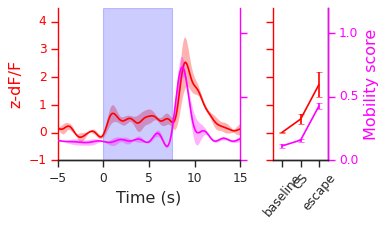

In [ ]:
atest.plotMeans('LHA-LHb','escapeCS',color='red',
                plot_type='mean and SEM',plot_event=[0,7.5],
                measure='movement',periods=['baseline','CS','escape'],
                w=[-5,15],ylim=[-1,4.5],xlim=[-5,15],
                subplot_ratio=[5,1.5],ylim1=[0,1.2],yticks1=[0,0.5,1],
                figsize=(5,3))
plt.show()

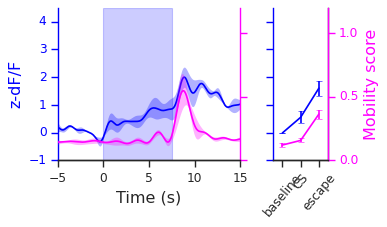

In [ ]:
atest.plotMeans('LHA-VTA','escapeCS',color='blue',
                plot_type='mean and SEM',plot_event=[0,7.5],
                measure='movement',periods=['baseline','CS','escape'],
                w=[-5,15],ylim=[-1,4.5],xlim=[-5,15],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,1.5],figsize=(5,3))
plt.show()

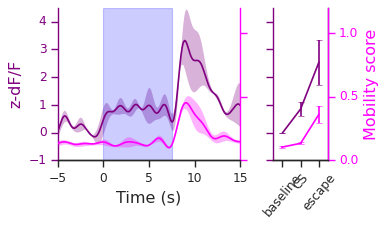

In [ ]:
atest.plotMeans('LHA-DRN','escapeCS',color='purple',
                plot_type='mean and SEM',plot_event=[0,7.5],
                measure='movement',periods=['baseline','CS','escape'],
                w=[-5,15],ylim=[-1,4.5],xlim=[-5,15],
                ylim1=[0,1.2],yticks1=[0,0.5,1.0],
                subplot_ratio=[5,1.5],figsize=(5,3))
plt.show()

#### Mobility onset at escape

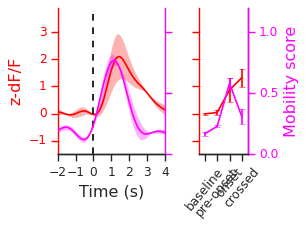

In [ ]:
atest.plotMeans('LHA-LHb','escape',color='red',
                plot_type='mean and SEM',
                measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                ylim=[-1.5,3.9],xlim=[-2,4],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,2.3],figsize=(4,3))
plt.show()

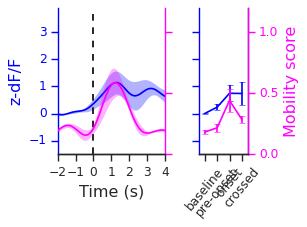

In [ ]:
atest.plotMeans('LHA-VTA','escape',color='blue',
                plot_type='mean and SEM',
                measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                ylim=[-1.5,3.9],xlim=[-2,4],
                subplot_ratio=[5,2.3],ylim1=[0,1.2],yticks1=[0,0.5,1],
                figsize=(4,3))
plt.show()

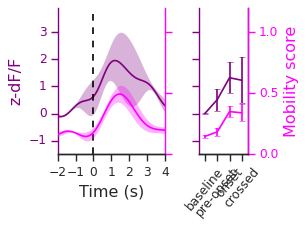

In [ ]:
atest.plotMeans('LHA-DRN','escape',color='purple',
                plot_type='mean and SEM',
                measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                ylim=[-1.5,3.9],xlim=[-2,4],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,2.3],figsize=(4,3))
plt.show()

#### CS before avoidance

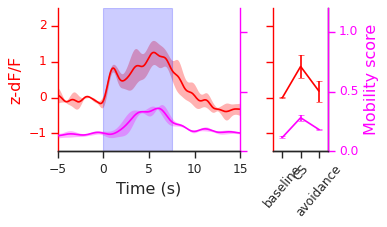

In [ ]:
atest.plotMeans('LHA-LHb','avoidanceCS',color='red',
                plot_type='mean and SEM',plot_event=[0,7.5],
                measure='movement',periods=['baseline','CS','avoidance'],
                w=[-5,15],ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-5,15],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,1.5],figsize=(5,3))
plt.show()

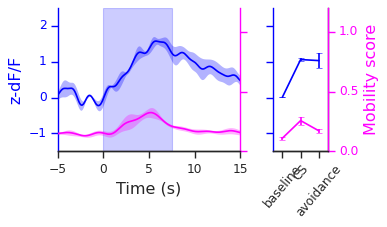

In [ ]:
atest.plotMeans('LHA-VTA','avoidanceCS',color='blue',
                plot_type='mean and SEM',plot_event=[0,7.5],
                measure='movement',periods=['baseline','CS','avoidance'],
                w=[-5,15],ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-5,15],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,1.5],figsize=(5,3))
plt.show()

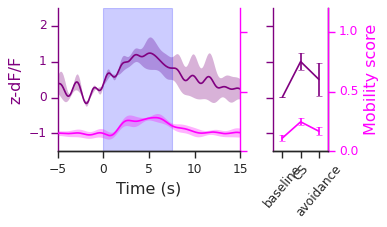

In [ ]:
atest.plotMeans('LHA-DRN','avoidanceCS',color='purple',
                plot_type='mean and SEM',plot_event=[0,7.5],
                measure='movement',periods=['baseline','CS','avoidance'],
                w=[-5,15],ylim=[-1.5,2.5],yticks=[-1,0,1,2],xlim=[-5,15],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,1.5],figsize=(5,3))
plt.show()

#### Mobility onset at avoidance

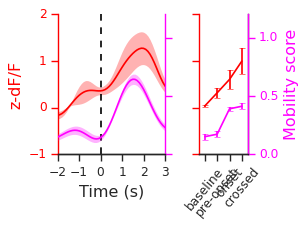

In [ ]:
atest.plotMeans('LHA-LHb','avoidance','onset',color='red',
                plot_type='mean and SEM',
                measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                ylim=[-1,2],yticks=[-1,0,1,2],xlim=[-2,3],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,2.3],figsize=(4,3),
                save=True,imgname='../avoidance_LHb.pdf')
plt.show()

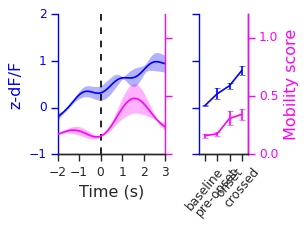

In [ ]:
atest.plotMeans('LHA-VTA','avoidance',color='blue',
                plot_type='mean and SEM',
                measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                ylim=[-1,2],yticks=[-1,0,1,2],xlim=[-2,3],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,2.3],figsize=(4,3),
                save=True,imgname='../avoidance_VTA.pdf')
plt.show()

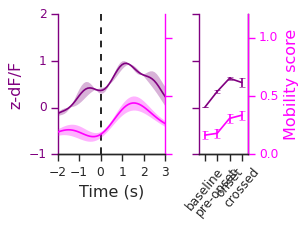

In [ ]:
atest.plotMeans('LHA-DRN','avoidance',color='purple',
                plot_type='mean and SEM',
                measure='movement',periods=['baseline','pre-onset','onset','crossed'],
                ylim=[-1,2],yticks=[-1,0,1,2],xlim=[-2,3],
                ylim1=[0,1.2],yticks1=[0,0.5,1],
                subplot_ratio=[5,2.3],figsize=(4,3),
                save=True,imgname='../avoidance_DRN.pdf')
plt.show()

# Save summary data to excel file for statistical analysis

In [ ]:
atrain = FiberPhotometryTest(filename,'Avoidance-Training')
atest = FiberPhotometryTest(filename,'Avoidance-Test')

Experiment information for test Avoidance-Training is successfully loaded.
Experiment information for test Avoidance-Test is successfully loaded.


In [ ]:
df_train_CS = atrain.getDataFrameAUC('escapeCS','onset',['baseline','CS','crossed'])
df_train_CS_mob = atrain.getDataFrameAUCmeasure('escapeCS','onset',['baseline','CS','crossed'])
df_test_CS = atest.getDataFrameAUC('escapeCS','onset',['baseline','CS','crossed'])
df_test_CS_mob = atest.getDataFrameAUCmeasure('escapeCS','onset',['baseline','CS','crossed'])
df_test_avoid = atest.getDataFrameAUC('avoidance','onset',['immobile','preonset','onset','mobile'])
df_test_avoid_mob = atest.getDataFrameAUCmeasure('avoidance','onset',['immobile','preonset','onset','mobile'])

In [ ]:
!pip install xlsxwriter
import xlsxwriter

In [ ]:
writer = pd.ExcelWriter('../sourcedata/fig4_LH_avoidanceTask.xlsx', engine='xlsxwriter')
df_learn.to_excel(writer, sheet_name='learningTask', index=False)
df_train_CS.to_excel(writer, sheet_name='earlyTr_CS-escape', index=False)
df_test_CS.to_excel(writer, sheet_name='lateTr_CS-escape', index=False)
df_train_CS_mob.to_excel(writer, sheet_name='earlyTr_CS-escape_mobileScore', index=False)
df_test_CS_mob.to_excel(writer, sheet_name='lateTr_CS-escape_mobileScore', index=False)
df_test_avoid.to_excel(writer, sheet_name='avoidance', index=False)
df_test_avoid_mob.to_excel(writer, sheet_name='avoidance_mobileScore', index=False)
writer.save()